<a href="https://colab.research.google.com/github/HadiAlizadeh1/mci-chatbot/blob/main/Task_007_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# In the name of ALLAH

# Tacotron 2 Training

This notebook is designed to provide a guide on how to train Tacotron2 as part of the TTS pipeline. It contains the following sections

  1. Tacotron2 and NeMo - An introduction to the Tacotron2 model
  2. LJSpeech - How to train Tacotron2 on LJSpeech
  3. Custom Datasets - How to collect audio data to train Tacotron2 for difference voices and languages

# License

> Copyright 2020 NVIDIA. All Rights Reserved.
> 
> Licensed under the Apache License, Version 2.0 (the "License");
> you may not use this file except in compliance with the License.
> You may obtain a copy of the License at
> 
>     http://www.apache.org/licenses/LICENSE-2.0
> 
> Unless required by applicable law or agreed to in writing, software
> distributed under the License is distributed on an "AS IS" BASIS,
> WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
> See the License for the specific language governing permissions and
> limitations under the License.

In [1]:
"""
You can either run this notebook locally (if you have all the dependencies and a GPU) or on Google Colab.
Instructions for setting up Colab are as follows:
1. Open a new Python 3 notebook.
2. Import this notebook from GitHub (File -> Upload Notebook -> "GITHUB" tab -> copy/paste GitHub URL)
3. Connect to an instance with a GPU (Runtime -> Change runtime type -> select "GPU" for hardware accelerator)
4. Run this cell to set up dependencies# .
"""
BRANCH = 'r1.13.0'
# # If you're using Colab and not running locally, uncomment and run this cell.
!apt-get install sox libsndfile1 ffmpeg
!pip install wget text-unidecode
!python -m pip install git+https://github.com/NVIDIA/NeMo.git@$BRANCH#egg=nemo_toolkit[all]
!wget https://raw.githubusercontent.com/NVIDIA/NeMo/main/nemo_text_processing/install_pynini.sh
!bash install_pynini.sh

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libsndfile1 is already the newest version (1.0.28-4ubuntu0.18.04.2).
ffmpeg is already the newest version (7:3.4.11-0ubuntu0.1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libmagic-mgc libmagic1 libopencore-amrnb0 libopencore-amrwb0 libsox-fmt-alsa
  libsox-fmt-base libsox3
Suggested packages:
  file libsox-fmt-all
The following NEW packages will be installed:
  libmagic-mgc libmagic1 libopencore-amrnb0 libopencore-amrwb0 libsox-fmt-alsa
  libsox-fmt-base libsox3 sox
0 upgraded, 8 newly installed, 0 to remove and 20 not upgraded.
Need to get 760 kB of archives.
After this operation, 6,717 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libopencore-amrnb0 amd64 0.1.3-2.1 [92.0 kB]
Get:2 http://

# Tacotron2 and NeMo

Tacotron2 is a neural network that converts text characters into a mel spectrogram. For more details on the model, please refer to Nvidia's [Tacotron2 Model Card](https://ngc.nvidia.com/catalog/models/nvidia:nemo:tts_en_tacotron2), or the original [paper](https://arxiv.org/abs/1712.05884).

Tacotron2 like most NeMo models are defined as a LightningModule, allowing for easy training via PyTorch Lightning, and parameterized by a configuration, currently defined via a yaml file and loading using Hydra.

Let's take a look using NeMo's pretrained model and how to use it to generate spectrograms.

In [3]:
# Load the Tacotron2Model
import nemo
from nemo.collections.tts.models import Tacotron2Model
from nemo.collections.tts.models.base import SpectrogramGenerator

# Let's see what pretrained models are available
print(Tacotron2Model.list_available_models())

[NeMo W 2022-12-15 19:09:36 optimizers:55] Apex was not found. Using the lamb or fused_adam optimizer will error out.
[NeMo W 2022-12-15 19:09:36 experimental:27] Module <class 'nemo_text_processing.g2p.modules.IPAG2P'> is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo W 2022-12-15 19:09:36 experimental:27] Module <class 'nemo.collections.common.tokenizers.text_to_speech.tts_tokenizers.IPATokenizer'> is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo W 2022-12-15 19:09:36 experimental:27] Module <class 'nemo.collections.tts.models.radtts.RadTTSModel'> is experimental, not ready for production and is not fully supported. Use at your own risk.


[PretrainedModelInfo(
	pretrained_model_name=tts_en_tacotron2,
	description=This model is trained on LJSpeech sampled at 22050Hz, and can be used to generate female English voices with an American accent.,
	location=https://api.ngc.nvidia.com/v2/models/nvidia/nemo/tts_en_tacotron2/versions/1.0.0/files/tts_en_tacotron2.nemo,
	class_=<class 'nemo.collections.tts.models.tacotron2.Tacotron2Model'>
)]


In [4]:
# We can load the pre-trained model as follows
model = Tacotron2Model.from_pretrained("tts_en_tacotron2")

[NeMo I 2022-12-15 19:09:38 cloud:66] Downloading from: https://api.ngc.nvidia.com/v2/models/nvidia/nemo/tts_en_tacotron2/versions/1.0.0/files/tts_en_tacotron2.nemo to /root/.cache/torch/NeMo/NeMo_1.13.0/tts_en_tacotron2/74d819609f47744063679b44e93a47f1/tts_en_tacotron2.nemo
[NeMo I 2022-12-15 19:10:02 common:911] Instantiating model from pre-trained checkpoint


[NeMo W 2022-12-15 19:10:04 modelPT:142] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      _target_: nemo.collections.asr.data.audio_to_text.AudioToCharDataset
      manifest_filepath: /raid/LJSpeech/nvidia_ljspeech_train.json
      max_duration: null
      min_duration: 0.1
      trim: false
      int_values: false
      load_audio: true
      normalize: true
      sample_rate: 22050
    dataloader_params:
      drop_last: false
      shuffle: true
      batch_size: 48
      num_workers: 4
    
[NeMo W 2022-12-15 19:10:04 modelPT:149] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    dataset:
      _target_: nemo.collections.asr.data.audio_to_

[NeMo I 2022-12-15 19:10:04 features:225] PADDING: 16
[NeMo I 2022-12-15 19:10:12 save_restore_connector:243] Model Tacotron2Model was successfully restored from /root/.cache/torch/NeMo/NeMo_1.13.0/tts_en_tacotron2/74d819609f47744063679b44e93a47f1/tts_en_tacotron2.nemo.


In [5]:
#!python -m pip uninstall matplotlib
#!pip install matplotlib==3.1.3

[NeMo W 2022-12-15 19:10:12 tacotron2:145] parse() is meant to be called in eval mode.


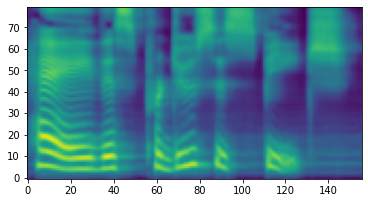

In [6]:
# Tacotron2 is a SpectrogramGenerator
assert isinstance(model, SpectrogramGenerator)

# SpectrogramGenerators in NeMo have two helper functions:
#   1. parse(self, text: str, normalize=True) which takes an English string and produces a token tensor
#   2. generate_spectrogram(self, *, tokens) which takes the token tensor and generates a spectrogram
# Let's try it out
tokens = model.parse(text = "Hey, this produces speech!")
spectrogram = model.generate_spectrogram(tokens = tokens)

# Now we can visualize the generated spectrogram
# If we want to generate speech, we have to use a vocoder in conjunction to a spectrogram generator.
# Refer to the TTS Inference notebook on how to convert spectrograms to speech.
from matplotlib.pyplot import imshow
from matplotlib import pyplot as plt
%matplotlib inline
imshow(spectrogram.cpu().detach().numpy()[0,...], origin="lower")
plt.show()

# Training

Now that we looked at the Tacotron2 model, let's see how to train a Tacotron2 Model



In [7]:
# NeMo's training scripts are stored inside the examples/ folder. Let's grab the tacotron2.py file
# as well as the tacotron2.yaml file
!wget https://raw.githubusercontent.com/NVIDIA/NeMo/$BRANCH/examples/tts/tacotron2.py
!(mkdir -p conf \
  && cd conf \
  && wget https://raw.githubusercontent.com/NVIDIA/NeMo/$BRANCH/examples/tts/conf/tacotron2.yaml \
  && cd ..)

# We will also need a few extra files for handling text.
!(mkdir -p scripts/tts_dataset_files \
  && cd scripts/tts_dataset_files \
  && wget https://raw.githubusercontent.com/NVIDIA/NeMo/$BRANCH/scripts/tts_dataset_files/cmudict-0.7b_nv22.08 \
  && wget https://raw.githubusercontent.com/NVIDIA/NeMo/$BRANCH/scripts/tts_dataset_files/heteronyms-052722 \
  && cd ..)
        
!(mkdir -p nemo_text_processing/text_normalization/en/data/whitelist/ \
  && cd nemo_text_processing/text_normalization/en/data/whitelist/ \
  && wget https://raw.githubusercontent.com/NVIDIA/NeMo/$BRANCH/nemo_text_processing/text_normalization/en/data/whitelist/lj_speech.tsv \
  && cd ..)

--2022-12-15 19:10:15--  https://raw.githubusercontent.com/NVIDIA/NeMo/r1.13.0/examples/tts/tacotron2.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1874 (1.8K) [text/plain]
Saving to: ‘tacotron2.py’

tacotron2.py        100%[===================>]   1.83K  --.-KB/s    in 0s      

2022-12-15 19:10:16 (33.5 MB/s) - ‘tacotron2.py’ saved [1874/1874]

--2022-12-15 19:10:16--  https://raw.githubusercontent.com/NVIDIA/NeMo/r1.13.0/examples/tts/conf/tacotron2.yaml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5451 (5.3K) [text/plai

Let's take a look at the tacotron2.py file

```python
import pytorch_lightning as pl

from nemo.collections.common.callbacks import LogEpochTimeCallback
from nemo.collections.tts.models import Tacotron2Model
from nemo.core.config import hydra_runner
from nemo.utils.exp_manager import exp_manager


# hydra_runner is a thin NeMo wrapper around Hydra
# It looks for a config named tacotron2.yaml inside the conf folder
# Hydra parses the yaml and returns it as a Omegaconf DictConfig
@hydra_runner(config_path="conf", config_name="tacotron2")
def main(cfg):
    # Define the Lightning trainer
    trainer = pl.Trainer(**cfg.trainer)
    # exp_manager is a NeMo construct that helps with logging and checkpointing
    exp_manager(trainer, cfg.get("exp_manager", None))
    # Define the Tacotron 2 model, this will construct the model as well as
    # define the training and validation dataloaders
    model = Tacotron2Model(cfg=cfg.model, trainer=trainer)
    # Let's add a few more callbacks
    lr_logger = pl.callbacks.LearningRateMonitor()
    epoch_time_logger = LogEpochTimeCallback()
    trainer.callbacks.extend([lr_logger, epoch_time_logger])
    # Call lightning trainer's fit() to train the model
    trainer.fit(model)


if __name__ == '__main__':
    main()  # noqa pylint: disable=no-value-for-parameter
```

Let's take a look at the yaml config

```yaml
name: &name Tacotron2

train_dataset: ???
validation_datasets: ???
sup_data_path: null
sup_data_types: null

phoneme_dict_path: "scripts/tts_dataset_files/cmudict-0.7b_nv22.08"
heteronyms_path: "scripts/tts_dataset_files/heteronyms-052722"
whitelist_path: "nemo_text_processing/text_normalization/en/data/whitelist/lj_speech.tsv"
```

The first part of the yaml defines dataset parameters used by Tacotron. Then in the head of 'model' section there are processing - related parameters. You can see
that the sample rate is set to 22050 for LJSpeech. 

Looking at the yaml, there is `train_dataset: ???` and `validation_datasets: ???`. The ??? indicates to hydra that these values must be passed via the command line or the script will fail.

Looking further down the yaml, we get to the pytorch lightning trainer parameters.

```yaml
trainer:
  devices: 1 # number of gpus
  accelerator: 'gpu' 
  max_epochs: ???
  num_nodes: 1
  accelerator: 'gpu'
  strategy: 'ddp'
  accumulate_grad_batches: 1
  enable_checkpointing: False  # Provided by exp_manager
  logger: False  # Provided by exp_manager
  gradient_clip_val: 1.0
  log_every_n_steps: 200
  check_val_every_n_epoch: 25
```

These values can be changed either by editing the yaml or through the command line.

Let's grab some simple audio data and test Tacotron2.

In [ ]:
!wget https://github.com/NVIDIA/NeMo/releases/download/v0.11.0/test_data.tar.gz \
&& mkdir -p tests/data \
&& tar xzf test_data.tar.gz -C tests/data

# Just like ASR, the Tacotron2 require .json files to define the training and validation data.
!cat tests/data/asr/an4_val.json

Now that we have some sample data, we can try training Tacotron 2!

Note that the sample data is not enough data to fully train a Tacotron 2 model. The following code uses a toy dataset to illustrate how the pipeline for training would work.

# Training Data

In order to train Tacotron2, it is highly recommended to obtain high quality speech data with the following properties:
  - Sampling rate of 22050Hz or higher
  - Single speaker
  - Speech should contain a variety of speech phonemes
  - Audio split into segments of 1-10 seconds
  - Audio segments should not have silence at the beginning and end
  - Audio segments should not contain long silences inside

After obtaining the speech data and splitting into training, validation, and test sections, it is required to construct .json files to tell NeMo where to find these audio files.

The .json files should adhere to the format required by the `nemo.collections.tts.torch.data.TTSDataset` class. For example, here is a sample .json file

```json
{"audio_filepath": "/path/to/audio1.wav", "text": "the transcription", "duration": 0.82}
{"audio_filepath": "/path/to/audio2.wav", "text": "the other transcription", "duration": 2.1}
...
```
Please note that the duration is in seconds.


Then you are ready to run your training script:
```bash
python tacotron2.py train_dataset=YOUR_TRAIN.json validation_datasets=YOUR_VAL.json trainer.devices=-1
```

## **Dataset preparation**
LJ-speech dataset

In [8]:
!wget "https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2" # download dataset
import tarfile
import os
os.mkdir("/content/DATASET")
tar = tarfile.open("/content/LJSpeech-1.1.tar.bz2", "r:bz2")  
tar.extractall("/content/DATASET") # save dataset in this path
tar.close()

--2022-12-15 19:10:18--  https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2
Resolving data.keithito.com (data.keithito.com)... 174.138.79.61
Connecting to data.keithito.com (data.keithito.com)|174.138.79.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2748572632 (2.6G) [application/octet-stream]
Saving to: ‘LJSpeech-1.1.tar.bz2’

LJSpeech-1.1.tar.bz 100%[===================>]   2.56G  36.4MB/s    in 73s     

2022-12-15 19:11:31 (36.0 MB/s) - ‘LJSpeech-1.1.tar.bz2’ saved [2748572632/2748572632]



## Spliting dataset to train and validation

In [9]:
# shuffeling dataset
import random
fid = open("/content/DATASET/LJSpeech-1.1/metadata.csv", "r")
li = fid.readlines()
fid.close()
#print(li)

random.shuffle(li)
#print(li)

fid = open("shuffled_example.csv", "w")
fid.writelines(li)
fid.close()

In [10]:
# 80% of data is about training data
# 20% of data is about validation data

import csv
import json
import wave
import contextlib
i=1
j=0
# opening the CSV file
with open(os.path.join('/content/DATASET/LJSpeech-1.1/metadata.csv'), encoding='utf-8') as f:
    for lines in f:   

        split_percent = 0.8
        df_length = int(10044*split_percent)
        #
        if i >= df_length+1:
            j=1
        parts = lines.strip().split('|')
        wav_path = os.path.join('/content/DATASET/LJSpeech-1.1/wavs','%s.wav' % parts[0])
        #

        fname = wav_path
        with contextlib.closing(wave.open(fname,'r')) as f:
          frames = f.getnframes()
          rate = f.getframerate()
          duration = frames / float(rate)
        #
        hostDict={"audio_filepath": wav_path , "text": parts[2] ,"duration": duration}
        #
        if j==0:
            with open('/content/train.json', 'a') as outfile:
                json.dump(hostDict, outfile)
                outfile.write('\n')

        if j==1:
            with open('/content/validation.json', 'a') as outfile:
                json.dump(hostDict, outfile)
                outfile.write('\n')   
        
        i=i+1


In [16]:
import csv
i=1
# opening the CSV file
with open('/content/train.json', mode ='r')as file:
   
  # reading the CSV file
  csvFile = csv.reader(file)
  
  # displaying the contents of the CSV file
  for lines in csvFile:
        print(lines)
        i=i+1
        if i==50:
          break
 

['{"audio_filepath": "/content/DATASET/LJSpeech-1.1/wavs/LJ001-0001.wav"', ' "text": "Printing', ' in the only sense with which we are at present concerned', ' differs from most if not from all the arts and crafts represented in the Exhibition"', ' "duration": 9.65501133786848}']
['{"audio_filepath": "/content/DATASET/LJSpeech-1.1/wavs/LJ001-0002.wav"', ' "text": "in being comparatively modern."', ' "duration": 1.899546485260771}']
['{"audio_filepath": "/content/DATASET/LJSpeech-1.1/wavs/LJ001-0003.wav"', ' "text": "For although the Chinese took impressions from wood blocks engraved in relief for centuries before the woodcutters of the Netherlands', ' by a similar process"', ' "duration": 9.666621315192744}']
['{"audio_filepath": "/content/DATASET/LJSpeech-1.1/wavs/LJ001-0004.wav"', ' "text": "produced the block books', ' which were the immediate predecessors of the true printed book', ', duration": 5.138730158730159}']
['{"audio_filepath": "/content/DATASET/LJSpeech-1.1/wavs/LJ001-000

## **Training model**

In [14]:
!git clone "https://github.com/NVIDIA/apex.git"

Cloning into 'apex'...
remote: Enumerating objects: 10686, done.
remote: Counting objects: 100% (208/208), done.
remote: Compressing objects: 100% (143/143), done.
remote: Total 10686 (delta 119), reused 118 (delta 65), pack-reused 10478
Receiving objects: 100% (10686/10686), 15.22 MiB | 19.70 MiB/s, done.
Resolving deltas: 100% (7347/7347), done.


In [15]:
!(python tacotron2.py \
  model.sample_rate=rate \
  train_dataset=/content/train.json \
  validation_datasets=/content/validation.json \
  trainer.max_epochs=30 \
  trainer.accelerator=null \
  trainer.check_val_every_n_epoch=1 \
 +trainer.gpus=1)

[NeMo W 2022-12-15 19:27:54 optimizers:55] Apex was not found. Using the lamb or fused_adam optimizer will error out.
[NeMo W 2022-12-15 19:27:55 experimental:27] Module <class 'nemo_text_processing.g2p.modules.IPAG2P'> is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo W 2022-12-15 19:27:55 experimental:27] Module <class 'nemo.collections.common.tokenizers.text_to_speech.tts_tokenizers.IPATokenizer'> is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo W 2022-12-15 19:27:55 experimental:27] Module <class 'nemo.collections.tts.models.radtts.RadTTSModel'> is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo W 2022-12-15 19:27:55 nemo_logging:349] /usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:447: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.